# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise import Dataset, Reader, KNNWithMeans
from surprise import SVD,SVDpp,NMF,SlopeOne
from surprise import NormalPredictor,KNNBasic,KNNWithMeans
from surprise import KNNBaseline,CoClustering,KNNWithZScore,BaselineOnly
from surprise import accuracy

from surprise.model_selection import cross_validate, train_test_split
from scipy.sparse import csr_matrix


In [2]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userID, artistID, weight)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [movie_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["normalized_weight"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [3]:
from sklearn.neighbors import NearestNeighbors


def find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given artist id.
    
    Args:
        artist_id: id of the artist of interest
        X: user-item utility matrix
        k: number of similar artist to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar artist ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
    # use k+1 since kNN output includes the artistId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [4]:
def recomendacion_artistas(name,k,dataset):
    
    artist_id = inv_map[name]
    #artists_names = dict(zip(artist_data['id'], artist_data['name']))
    artists_names = artist_dict
    similar_artist = find_similar_artists(artist_id, dataset, movie_mapper, movie_inv_mapper, 
                                          metric='cosine', k=k)
    artist_name = artist_dict[artist_id]
    print(f"Dado que escuchaste {artist_name} podés escuchar:")
    for i in similar_artist:
           print(artists_names[i])

## Datasets

### artist_data

In [5]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [6]:
artist_dict = dict(zip(artist_data.id, artist_data.name))
artist_dict

{1: 'MALICE MIZER',
 2: 'Diary of Dreams',
 3: 'Carpathian Forest',
 4: 'Moi dix Mois',
 5: 'Bella Morte',
 6: 'Moonspell',
 7: 'Marilyn Manson',
 8: 'DIR EN GREY',
 9: 'Combichrist',
 10: 'Grendel',
 11: 'Agonoize',
 12: 'Behemoth',
 13: 'Hocico',
 15: 'Dimmu Borgir',
 16: 'London After Midnight',
 17: 'Psyclon Nine',
 18: 'The Crüxshadows',
 19: ':wumpscut:',
 20: 'Limbonic Art',
 21: 'Artista sconosciuto',
 22: 'xotox',
 23: 'The Kovenant',
 24: 'Feindflug',
 25: 'Cradle of Filth',
 26: 'Tamtrum',
 27: 'Laibach',
 28: 'Gorgoroth',
 30: 'And One',
 31: 'Amduscia',
 32: 'Covenant',
 34: 'Icon of Coil',
 36: 'KMFDM',
 37: 'Funker Vogt',
 38: 'Dawn of Ashes',
 39: 'Sopor Aeternus & The Ensemble of Shadows',
 40: 'The Faint',
 41: 'God Module',
 43: 'Noisuf-X',
 44: 'Das Ich',
 45: 'Mindless Self Indulgence',
 46: 'Pyotr Ilyich Tchaikovsky',
 47: 'Emperor',
 48: 'Anorexia Nervosa',
 49: 'Reaper',
 50: 'Gothminister',
 51: 'Duran Duran',
 52: 'Morcheeba',
 53: 'Air',
 54: 'Hooverphonic',


### user_artist

In [7]:
user_artist = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


### tags

In [8]:
tags = pd.read_csv("./data/lastfm/tags.dat", sep = '\t', encoding = 'latin-1')
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [9]:
tags_dict = dict(zip(tags.tagID, tags.tagValue))
tags_dict

{1: 'metal',
 2: 'alternative metal',
 3: 'goth rock',
 4: 'black metal',
 5: 'death metal',
 6: 'industrial metal',
 7: 'gothic metal',
 8: 'terror ebm',
 9: 'electro-industrial',
 10: 'harsh ebm',
 11: 'post black metal',
 12: 'aggrotech',
 13: 'chillout',
 14: 'ambient',
 15: 'downtempo',
 16: 'new wave',
 17: 'synth pop',
 18: 'electronic',
 19: "80's",
 20: 'lounge',
 21: 'trip-hop',
 22: 'acid jazz',
 23: 'new age',
 24: 'pop',
 25: '80s',
 26: 'atmospheric',
 27: 'ethereal',
 28: 'deutsch',
 29: 'schlager',
 30: 'german',
 31: 'hi-nrg',
 32: 'avant-garde',
 33: 'experimental',
 34: 'minimal',
 35: 'cyberpunk',
 36: 'club house',
 37: 'groove',
 38: 'cafe del mar',
 39: 'dance',
 40: 'gregorian chant',
 41: 'female vovalists',
 42: 'synth-pop',
 43: 'classic 80s',
 44: 'glitch',
 45: 'u-cover',
 46: 'melancholy',
 47: 'idm',
 48: 'vu-us',
 49: 'female vocalist',
 50: 'modern classical',
 51: 'clicks and cuts',
 52: 'databloem',
 53: 'field recording',
 54: 'october man recordings

### user_taggedartists

In [10]:
user_tagged_artists = pd.read_csv("./data/lastfm/user_taggedartists.dat", sep = '\t')
user_tagged_artists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [11]:
user_artist["artist_name"]  = user_artist["artistID"].map(artist_dict) 
user_artist

,userID,artistID,weight,artist_name
0,2,51,13883,Duran Duran
1,2,52,11690,Morcheeba
2,2,53,11351,Air
3,2,54,10300,Hooverphonic
4,2,55,8983,Kylie Minogue
...,...,...,...,...
92829,2100,18726,337,Nyktalgia
92830,2100,18727,297,Atsakau niekadA
92831,2100,18728,281,Domantas Razauskas
92832,2100,18729,280,Atalyja


Veamos la distribución de weight en el dataset anterior:

In [12]:
user_artist['weight'].describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [13]:
number_users = user_artist['userID'].nunique()
print(f"Cantidad de usuarios: {number_users}")

Cantidad de usuarios: 1892


In [14]:
numbers_artists = user_artist['artistID'].nunique()
print(f'Cantidad de artistas:{numbers_artists}')

Cantidad de artistas:17632


A continuación mostramos la cantidad de listens por artistas:

In [15]:
df1 = user_artist[['artistID',
                         'weight','artist_name']].groupby(
                        ['artistID','artist_name']).agg({'sum'}).reset_index()
df1.columns = df1.columns.droplevel(1)
df1

,artistID,artist_name,weight
0,1,MALICE MIZER,771
1,2,Diary of Dreams,8012
2,3,Carpathian Forest,775
3,4,Moi dix Mois,563
4,5,Bella Morte,913
...,...,...,...
17627,18741,Diamanda Galás,301
17628,18742,Aya RL,294
17629,18743,Coptic Rain,287
17630,18744,Oz Alchemist,286


A continuación en la distribución del weight por artista observamos que los datos presentan una desviación estándar importante, lo cual se refleja en la diferencia de 6 ordenes entre el mínimo y el máximo.

In [16]:
df1['weight'].describe()

count    1.763200e+04
mean     3.923774e+03
std      3.409934e+04
min      1.000000e+00
25%      1.130000e+02
50%      3.500000e+02
75%      1.234250e+03
max      2.393140e+06
Name: weight, dtype: float64

In [17]:
print('Los artistas más escuchados son:')
df1 = df1.sort_values(by=['weight','artistID'], ascending=[False,False])
df1.head(50)

Los artistas más escuchados son:


,artistID,artist_name,weight
283,289,Britney Spears,2393140
66,72,Depeche Mode,1301308
83,89,Lady Gaga,1291387
286,292,Christina Aguilera,1058405
492,498,Paramore,963449
61,67,Madonna,921198
282,288,Rihanna,905423
695,701,Shakira,688529
221,227,The Beatles,662116
294,300,Katy Perry,532545


In [18]:
print('Los artistas menos escuchados son:')
df1 = df1.sort_values(by=['weight','artistID'], ascending=[False,False])
df1.tail(50)

Los artistas menos escuchados son:


,artistID,artist_name,weight
11964,12401,Curiosity Killed the Cat,1
11352,11751,Bored Housewife,1
11351,11750,Sodaphon,1
11350,11749,Luke Buda,1
11349,11748,Sore Eros,1
11348,11747,The Reduction Agents,1
11347,11746,Ayn Rand,1
11346,11745,Herman Düne,1
11256,11644,B.o.B feat. Eminem & Hayley Williams,1
10907,11251,Rodrigo e Rogerio,1


Veamos una visualización:

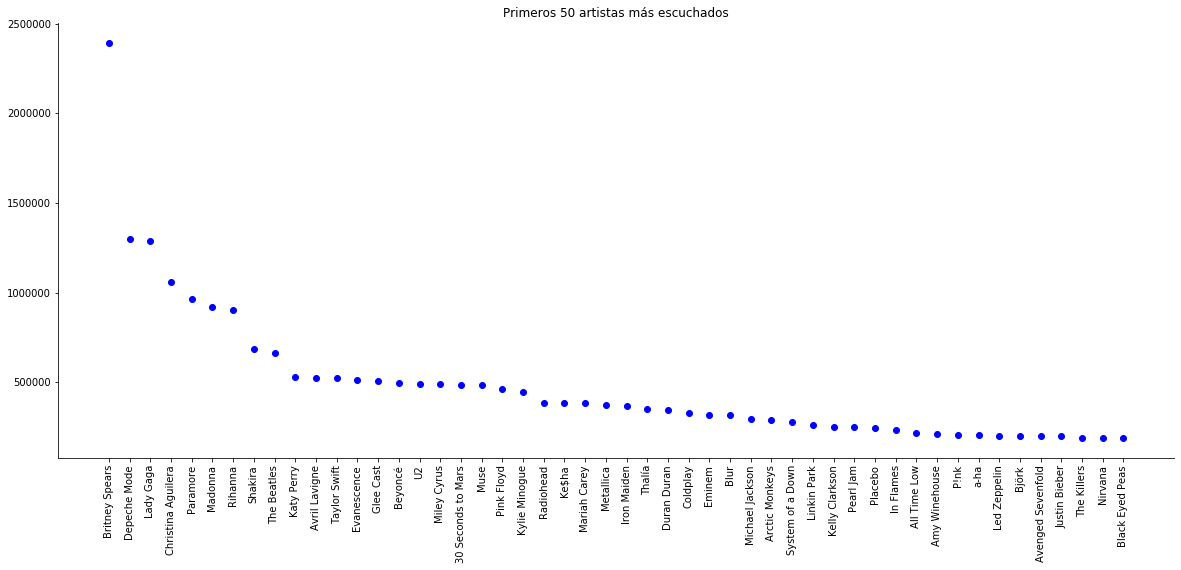

In [19]:
plt.figure(figsize=(20,8))
plt.plot(df1['artist_name'].head(50),
         df1['weight'].head(50),'bo'
         )
plt.xticks(rotation=90)
plt.title('Primeros 50 artistas más escuchados')
sns.despine()

Veamos ahora la cantidad de listens totales por usuario y su distribución:

In [20]:
df2 = user_artist[['userID','weight']].groupby(['userID']).agg({'sum'}).reset_index()
df2.columns = df2.columns.droplevel(1)
df2

,userID,weight
0,2,168737
1,3,20501
2,4,26930
3,5,13159
4,6,1011
...,...,...
1887,2095,4885
1888,2096,62714
1889,2097,13830
1890,2099,10179


In [21]:
df2['weight'].describe()

count      1892.000000
mean      36566.582981
std       48744.552394
min           3.000000
25%        9742.250000
50%       21573.000000
75%       42963.750000
max      480039.000000
Name: weight, dtype: float64

Nuevamente nuestra variable weight tiene datos bastante dispersos.

In [22]:
print('Usuarios con mayor cantidad de listens:')
df2 = df2.sort_values(by=['weight','userID'], ascending=[False,False])
df2.head(50)

Usuarios con mayor cantidad de listens:


,userID,weight
705,757,480039
1802,2000,468409
1280,1418,416349
1482,1642,388251
1002,1094,379125
1751,1942,348527
1867,2071,338400
1830,2031,329980
481,514,329782
361,387,322661


In [23]:
print('Usuarios con menor cantidad de listens:')
df2 = df2.sort_values(by=['weight','userID'], ascending=[False,False])
df2.tail(50)

Usuarios con menor cantidad de listens:


,userID,weight
1036,1134,424
1466,1625,423
1641,1818,415
1219,1347,382
270,290,363
715,768,357
569,613,337
409,438,334
745,802,326
516,552,317


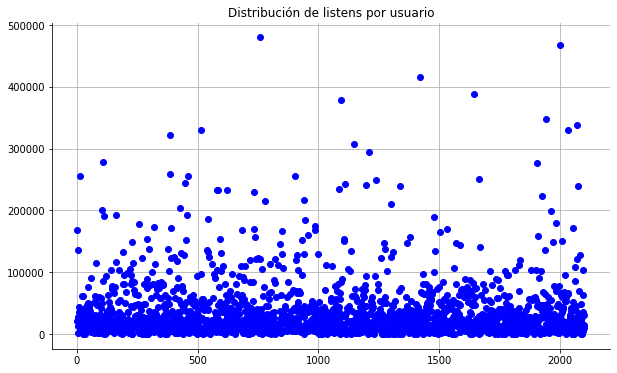

In [24]:
plt.figure(figsize=(10,6))
plt.plot(df2['userID'],df2['weight'],'bo')
plt.grid()
plt.title('Distribución de listens por usuario')
sns.despine()

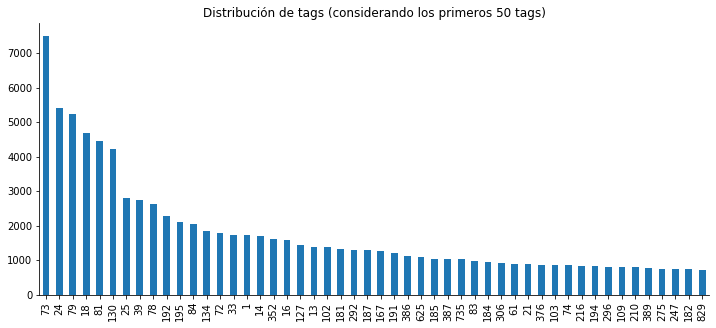

In [25]:
plt.figure(figsize=(12,5))
user_tagged_artists['tagID'].value_counts().head(50).plot(kind='bar')
plt.title('Distribución de tags (considerando los primeros 50 tags)')
sns.despine()

In [26]:
print('5 tags más frecuentes son:')
print(tags_dict[73])
print(tags_dict[24])
print(tags_dict[79])
print(tags_dict[18])
print(tags_dict[81])
print(tags_dict[130])

5 tags más frecuentes son:
rock
pop
alternative
electronic
indie
female vocalists


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [27]:
user_artist

,userID,artistID,weight,artist_name
0,2,51,13883,Duran Duran
1,2,52,11690,Morcheeba
2,2,53,11351,Air
3,2,54,10300,Hooverphonic
4,2,55,8983,Kylie Minogue
...,...,...,...,...
92829,2100,18726,337,Nyktalgia
92830,2100,18727,297,Atsakau niekadA
92831,2100,18728,281,Domantas Razauskas
92832,2100,18729,280,Atalyja


Calculamos la suma de listens por usuarios y luego creamos un dictionario para incorporar este feature en la matriz original.

In [28]:
user_weight_sum = user_artist[['userID','weight']].groupby(['userID']).agg({'sum'}).reset_index()
user_weight_sum.columns = user_weight_sum.columns.droplevel(1)
user_weight_sum

,userID,weight
0,2,168737
1,3,20501
2,4,26930
3,5,13159
4,6,1011
...,...,...
1887,2095,4885
1888,2096,62714
1889,2097,13830
1890,2099,10179


In [29]:
user_weight_sum_dict = dict(zip(user_weight_sum['userID'], user_weight_sum['weight']))
user_weight_sum_dict

{2: 168737,
 3: 20501,
 4: 26930,
 5: 13159,
 6: 1011,
 7: 135399,
 8: 36279,
 9: 25597,
 10: 28523,
 11: 42920,
 12: 256144,
 13: 4211,
 14: 34681,
 15: 19863,
 16: 14101,
 17: 34839,
 18: 20311,
 20: 9052,
 21: 23493,
 22: 61844,
 23: 16521,
 24: 60844,
 25: 23039,
 26: 30657,
 27: 5738,
 28: 499,
 29: 7327,
 30: 17234,
 31: 28034,
 32: 33019,
 33: 41460,
 34: 38212,
 35: 21,
 36: 28146,
 37: 15275,
 38: 12113,
 39: 3691,
 40: 21213,
 41: 46822,
 42: 21316,
 43: 28525,
 44: 16137,
 45: 44341,
 46: 76348,
 47: 50761,
 48: 29346,
 49: 7612,
 50: 42435,
 51: 33637,
 52: 8912,
 53: 13791,
 54: 23743,
 55: 26787,
 56: 37899,
 57: 49276,
 58: 27367,
 59: 90748,
 60: 3351,
 61: 15962,
 62: 16660,
 63: 7902,
 64: 13866,
 65: 16406,
 66: 27581,
 68: 13200,
 69: 17151,
 70: 24578,
 71: 12955,
 72: 837,
 73: 21119,
 74: 52966,
 75: 25941,
 76: 62052,
 77: 31308,
 78: 10720,
 79: 115330,
 80: 9658,
 81: 11207,
 82: 16256,
 83: 47184,
 84: 22743,
 85: 7940,
 86: 23936,
 87: 2368,
 88: 1053,
 89: 

In [30]:
user_artist["sum_by_user"]  = user_artist["userID"].map(user_weight_sum_dict) 
user_artist

,userID,artistID,weight,artist_name,sum_by_user
0,2,51,13883,Duran Duran,168737
1,2,52,11690,Morcheeba,168737
2,2,53,11351,Air,168737
3,2,54,10300,Hooverphonic,168737
4,2,55,8983,Kylie Minogue,168737
...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,30877
92830,2100,18727,297,Atsakau niekadA,30877
92831,2100,18728,281,Domantas Razauskas,30877
92832,2100,18729,280,Atalyja,30877


In [31]:
user_artist['normalized_weight']= user_artist['weight']/user_artist['sum_by_user']
user_artist

,userID,artistID,weight,artist_name,sum_by_user,normalized_weight
0,2,51,13883,Duran Duran,168737,0.082276
1,2,52,11690,Morcheeba,168737,0.069279
2,2,53,11351,Air,168737,0.067270
3,2,54,10300,Hooverphonic,168737,0.061042
4,2,55,8983,Kylie Minogue,168737,0.053237
...,...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,30877,0.010914
92830,2100,18727,297,Atsakau niekadA,30877,0.009619
92831,2100,18728,281,Domantas Razauskas,30877,0.009101
92832,2100,18729,280,Atalyja,30877,0.009068


In [32]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper= create_X(user_artist[['userID','artistID','normalized_weight']])

In [33]:
n_total = X.shape[0]*X.shape[1]
n_weight = X.nnz
sparsity = n_weight/n_total
print(f"Esparcidad de la matriz: {round(sparsity*100,2)}%")

Esparcidad de la matriz: 0.28%


### PRUEBAS!!

In [34]:
matriz = user_artist.pivot(index='userID', columns='artistID', values='normalized_weight')
matriz.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
## FILAS,COLUMNAS CON VALORES NULOS
nulos = matriz.isnull().stack()[lambda x: x].index.tolist()
nulos

[(2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 30),
 (2, 31),
 (2, 32),
 (2, 34),
 (2, 36),
 (2, 37),
 (2, 38),
 (2, 39),
 (2, 40),
 (2, 41),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 47),
 (2, 48),
 (2, 49),
 (2, 50),
 (2, 101),
 (2, 102),
 (2, 103),
 (2, 104),
 (2, 105),
 (2, 106),
 (2, 107),
 (2, 108),
 (2, 109),
 (2, 110),
 (2, 111),
 (2, 112),
 (2, 113),
 (2, 114),
 (2, 115),
 (2, 116),
 (2, 117),
 (2, 118),
 (2, 119),
 (2, 120),
 (2, 121),
 (2, 122),
 (2, 123),
 (2, 124),
 (2, 125),
 (2, 126),
 (2, 127),
 (2, 128),
 (2, 129),
 (2, 130),
 (2, 131),
 (2, 132),
 (2, 133),
 (2, 134),
 (2, 135),
 (2, 136),
 (2, 137),
 (2, 138),
 (2, 139),
 (2, 140),
 (2, 141),
 (2, 142),
 (2, 143),
 (2, 144),
 (2, 145),
 (2, 146),
 (2, 147),
 (2, 148),
 (2, 149),
 (2, 150),
 (2, 151)

In [37]:
nulos[0][0]

2

In [38]:
nulos[0][1]

1

In [41]:
matriz.iloc[2][108]

nan

In [42]:
matriz.iloc[2][271]

nan

In [43]:
## FILAS/COLUMNAS CON VALORES
nonulos = matriz.notnull().stack()[lambda x: x].index.tolist()
nonulos

[(2, 51),
 (2, 52),
 (2, 53),
 (2, 54),
 (2, 55),
 (2, 56),
 (2, 57),
 (2, 58),
 (2, 59),
 (2, 60),
 (2, 61),
 (2, 62),
 (2, 63),
 (2, 64),
 (2, 65),
 (2, 66),
 (2, 67),
 (2, 68),
 (2, 69),
 (2, 70),
 (2, 71),
 (2, 72),
 (2, 73),
 (2, 74),
 (2, 75),
 (2, 76),
 (2, 77),
 (2, 78),
 (2, 79),
 (2, 80),
 (2, 81),
 (2, 82),
 (2, 83),
 (2, 84),
 (2, 85),
 (2, 86),
 (2, 87),
 (2, 88),
 (2, 89),
 (2, 90),
 (2, 91),
 (2, 92),
 (2, 93),
 (2, 94),
 (2, 95),
 (2, 96),
 (2, 97),
 (2, 98),
 (2, 99),
 (2, 100),
 (3, 101),
 (3, 102),
 (3, 103),
 (3, 104),
 (3, 105),
 (3, 106),
 (3, 107),
 (3, 108),
 (3, 109),
 (3, 110),
 (3, 111),
 (3, 112),
 (3, 113),
 (3, 114),
 (3, 115),
 (3, 116),
 (3, 117),
 (3, 118),
 (3, 119),
 (3, 120),
 (3, 121),
 (3, 122),
 (3, 123),
 (3, 124),
 (3, 125),
 (3, 126),
 (3, 127),
 (3, 128),
 (3, 129),
 (3, 130),
 (3, 131),
 (3, 132),
 (3, 133),
 (3, 134),
 (3, 135),
 (3, 136),
 (3, 137),
 (3, 138),
 (3, 139),
 (3, 140),
 (3, 141),
 (3, 142),
 (3, 143),
 (3, 144),
 (3, 145),
 (3,

In [44]:
matriz.loc[2][51]

0.08227596792641803

In [45]:
matriz.loc[6][282]

0.013847675568743818

In [46]:
matriz.loc[4][174]

0.010657259561826959

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [47]:
reader = Reader(rating_scale=(user_artist['normalized_weight'].min(), 
                              user_artist['normalized_weight'].max()))

weight = Dataset.load_from_df(user_artist[['userID', 'artistID', 'normalized_weight']], reader)

weight_train, weight_test = train_test_split(weight, test_size=0.2)


In [48]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), 
                  NMF(), NormalPredictor(), KNNBaseline(), 
                  KNNBasic(), KNNWithMeans(), KNNWithZScore(), 
                  BaselineOnly(), CoClustering()]:
    print('Modelo:', str(algorithm).split(' ')[0].split('.')[-1] )

    # Perform cross validation
    results = cross_validate(algorithm, weight, measures=['RMSE','MAE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Modelo: SVD
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0656  0.0667  0.0667  0.0663  0.0005  
MAE (testset)     0.0409  0.0407  0.0415  0.0410  0.0004  
Fit time          2.56    2.62    2.62    2.60    0.03    
Test time         0.16    0.16    0.15    0.15    0.00    
Modelo: SVDpp
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0463  0.0444  0.0457  0.0455  0.0008  
MAE (testset)     0.0262  0.0259  0.0261  0.0261  0.0001  
Fit time          24.04   23.39   24.19   23.87   0.34    
Test time         1.02    1.01    1.01    1.02    0.00    
Modelo: SlopeOne
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.0378  0.0369  0.0397  0.0381  0.0012  
MAE (testset)     0.0153  0.0153  0.0156  0.0154  0.0001  
Fit time          3.1

In [49]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [50]:
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.036706,0.015151,0.272319,0.353728
KNNBasic,0.037214,0.015765,0.281973,1.841069
KNNBaseline,0.037490,0.015970,0.559490,2.217091
SlopeOne,0.038108,0.015387,3.433483,0.810334
KNNWithMeans,0.038123,0.016324,0.306701,2.401184
KNNWithZScore,0.040012,0.016530,0.384365,2.304885
CoClustering,0.042095,0.019783,2.575088,0.628141
NMF,0.042109,0.019812,3.770715,0.123982
SVDpp,0.045466,0.026065,23.873848,1.015020


In [51]:
#data = user_artist[['userID', 'artistID', 'normalized_weight']]
trainset = weight.build_full_trainset()

model=BaselineOnly()
model.fit(trainset)


Estimating biases using als...


In [52]:
pred= model.predict(uid='2',iid='51',verbose=True)
score=pred.est
print(score)

user: 2          item: 51         r_ui = None   est = 0.02   {'was_impossible': False}
0.020380464054118103


In [53]:
pred= model.predict(uid='2',iid='50',verbose=True)
score=pred.est
print(score)

user: 2          item: 50         r_ui = None   est = 0.02   {'was_impossible': False}
0.020380464054118103


In [54]:
pred= model.predict(uid='2',iid='52',verbose=True)
score=pred.est
print(score)

user: 2          item: 52         r_ui = None   est = 0.02   {'was_impossible': False}
0.020380464054118103


In [55]:
pred= model.predict(uid='4',iid='174',verbose=True)
score=pred.est
print(score)

user: 4          item: 174        r_ui = None   est = 0.02   {'was_impossible': False}
0.020380464054118103


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

#### Evaluando la esparsidad de la matriz

In [56]:
n_total = X.shape[0]*X.shape[1]
n_weight = X.nnz
sparsity = n_weight/n_total
print(f"Esparcidad de la matriz: {round(sparsity*100,2)}%")

Esparcidad de la matriz: 0.28%


In [57]:
n_weight_por_usuario = X.getnnz(axis=1)

print(f"El usuario más activo ha escuchado {n_weight_por_usuario.max()} artistas.")
print(f"El usuario menos activo ha escuchado {n_weight_por_usuario.min()} artistas.")

El usuario más activo ha escuchado 50 artistas.
El usuario menos activo ha escuchado 1 artistas.


In [58]:
n_weights_por_artista = X.getnnz(axis=0)

print(f"El artista más escuchado ha recibido {n_weights_por_artista.max()} listens.")
print(f"El artista menos escuchado ha recibido {n_weights_por_artista.min()} listens.")

El artista más escuchado ha recibido 611 listens.
El artista menos escuchado ha recibido 1 listens.


Veamos las distribuciones de listens por usuario y por artista:

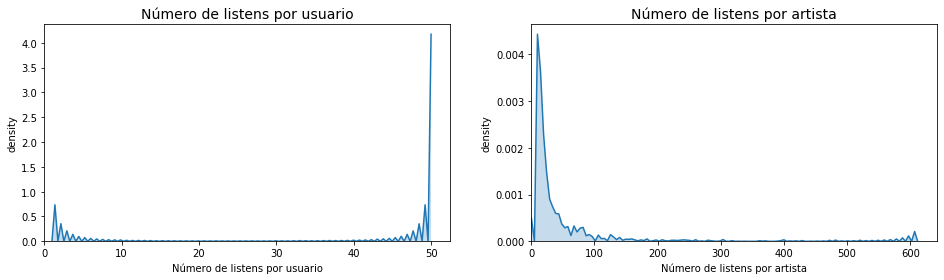

In [59]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_weight_por_usuario, shade=True)
plt.xlim(0)
plt.title("Número de listens por usuario", fontsize=14)
plt.xlabel("Número de listens por usuario")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_weights_por_artista, shade=True)
plt.xlim(0)
plt.title("Número de listens por artista", fontsize=14)
plt.xlabel("Número de listens por artista")
plt.ylabel("density")
plt.show()

In [60]:
#sum_weights_por_artista = X.sum(axis=0)
#mean_weights_por_artista = sum_weights_por_artista/n_weights_por_artista

In [61]:
#X_mean_artista = np.tile(mean_weights_por_artista, (X.shape[0],1))


In [62]:
#X_mean_artista.shape


In [63]:
#X_norm = X - csr_matrix(X_mean_artista)


In [64]:
#print("Original X:", X[0].todense())
#print("Normalized X:", X_norm[0].todense())

In [65]:
#similar_movies = find_similar_artists(89, X_norm, movie_mapper, movie_inv_mapper, k=10)
#similar_movies = pd.DataFrame(similar_movies)
#similar_movies

In [66]:
inv_map = {v: k for k, v in artist_dict.items()}

#### Recomendación Shakira

In [67]:
recomendacion_artistas('Shakira',10,X)

Dado que escuchaste Shakira podés escuchar:
Xtuna
Sara Bareilles & Ingrid Michaelson
Angélico & Diana
Hope
Cameron Cartio
Karl Wolf
Outlandish
Sunidhi Chauhan
Shreya Ghoshal & Shaan


In [68]:
recomendacion_artistas('Shakira',10,X_norm)

NameError: name 'X_norm' is not defined

#### Recomendación Lady Gaga

In [69]:
recomendacion_artistas('Lady Gaga',10,X)

Dado que escuchaste Lady Gaga podés escuchar:
Tom Felton
Ke$ha
Black Eyed Peas
Katy Perry
CJ Holland
Rihanna
Britney Spears
Lelia Broussard
Semi Precious Weapons


In [ ]:
recomendacion_artistas('Lady Gaga',10,X_norm)

#### Recomendación U2

In [70]:
recomendacion_artistas('U2',10,X)

Dado que escuchaste U2 podés escuchar:
Bono
Coldplay/U2
Bono & The Mdh Band
Astonvilla
Bono, Glen Hansard & Damien Rice
Playing For Change
Passengers
Hyper vs. the Crystal Method
Anna Reynolds, Philip Langridge; Neville Marriner: Academy Of St. Martin In The Fields


In [ ]:
recomendacion_artistas('U2',10,X_norm)

#### Recomendación Madonna

In [71]:
recomendacion_artistas('Madonna',10,X)

Dado que escuchaste Madonna podés escuchar:
Jia Peng Fang
Madonna & Justin Timberlake & Timbaland
Mamma Mia! Brasil
ABBA
Agnetha Fältskog
Based On Abba
Madonna feat. Gogol Bordello
Mamma Mia! Film Cast
Jared Padalecki


In [ ]:
recomendacion_artistas('Madonna',10,X_norm)

#### Recomendación Britney Spears

In [72]:
recomendacion_artistas('Britney Spears',10,X)

Dado que escuchaste Britney Spears podés escuchar:
Hilary Duff
The Pussycat Dolls
Lindsay Lohan
Jennifer Lopez vs Britney Spea
themaddnesstrack
Grupo Rouge !!!
Daniel Rolim
Junior Ferrari
Black Eyed Peas


In [ ]:
recomendacion_artistas('Britney Spears',10,X_norm)

#### Recomendación Avril Lavigne

In [73]:
recomendacion_artistas('Avril Lavigne',10,X)

Dado que escuchaste Avril Lavigne podés escuchar:
민호
Jang Geun Suk & Park Shin Hye
제빵왕
Dirty Little Rabbits
Sabrina
Maksim Mrvica
Cinta Laura
미스에이(miss A)
B1A4


In [ ]:
recomendacion_artistas('Avril Lavigne',10,X_norm)

#### Recomendación Rihanna

In [74]:
recomendacion_artistas('Rihanna',10,X)

Dado que escuchaste Rihanna podés escuchar:
Rihanna-remixado REnan
Jay-Z, Bono, The Edge & Rihanna
Black Eyed Peas
Katy Perry
Willow
Acid Black Cherry
島谷ひとみ
Janne Da Arc
Shontelle


In [ ]:
recomendacion_artistas('Rihanna',10,X_norm)

#### Recomendación Pink Floyd

In [75]:
recomendacion_artistas('Pink Floyd', 10,X)


Dado que escuchaste Pink Floyd podés escuchar:
Neu!
Rare Bird
ciëlo
Kleitman, Michael
Acoustic brasil
Plácido Domingo
LTJ Bukem
Merlinmoon
Brazilution


In [ ]:
recomendacion_artistas('Pink Floyd', 10,X_norm)


#### Recomendación The Beatles

In [76]:
recomendacion_artistas('The Beatles', 10,X)


Dado que escuchaste The Beatles podés escuchar:
John Lennon
Paul McCartney
Onision
The J. Geils Band
Leonel García
Nicho Hinojosa
Santo & Johnny
Leon Polar
Los Shakers


In [ ]:
recomendacion_artistas('The Beatles', 10,X_norm)
